# Finding chessboard corners

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# %matplotlib inline
%matplotlib notebook

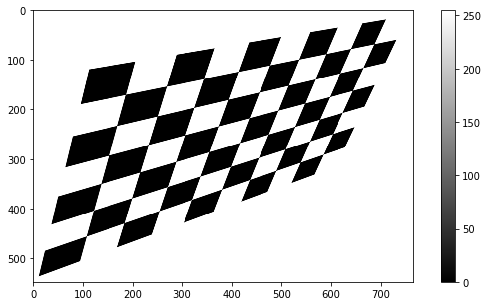

In [2]:
# Load data
fn = "images/chessboard1.png"
grid_size = (9, 6)  # Num of intersections (x, y)
im = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
# im = cv2.resize(im, dsize=(640, 480), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10, 5)), plt.imshow(im, cmap='gray'), plt.colorbar();

## Find the chessboard

### Take the derivative of the image

To find the edges of the board and also to normalize the gray level.

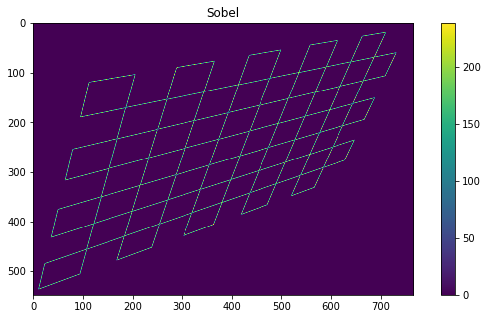

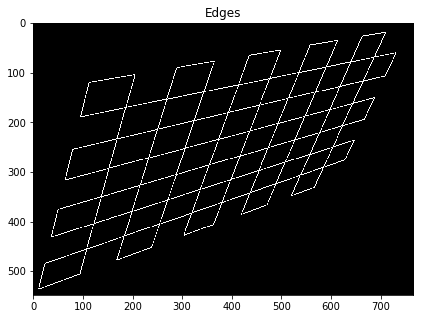

In [3]:
im = im.astype(float)
gx, gy = np.zeros_like(im), np.zeros_like(im)
gx[:, :-1] = im[:, 1:] - im[:, :-1]  # X derivative
gy[:-1, :] = im[1:, :] - im[:-1, :]  # Y derivative
g = np.sqrt(gx**2 + gy**2)           # Gradient absolute value
g = np.abs(g)
bw = g > 50
plt.figure(figsize=(10, 5)), plt.imshow(g, cmap='viridis'), plt.title("Sobel"), plt.colorbar();
plt.figure(figsize=(10, 5)), plt.imshow(bw, cmap='gray'), plt.title("Edges");

### Hough Transform

Find the major lines equation using Hough transform.
We use polar coordinates instead of the regular $y=ax+b$ to avoid numerical issues when the denominator is very small. We will represent a straight line by a rotation angle $\theta$ and the distance from the top-left corner $r$.

$x=r\cos{\theta}$

$y=r\sin{\theta}$

In [4]:
# Building a list of points
points_y, points_x = np.where(bw)
pts_xy = np.vstack((points_x, points_y)).T
print(pts_xy)
print("Num of points: {}".format(len(pts_xy)))

[[707  18]
 [708  18]
 [709  18]
 ...
 [ 12 535]
 [ 13 535]
 [ 14 535]]
Num of points: 14419


In [5]:
# We go over each point and find and check for each theta angle what is
# the staright line that goes through this point
hough_space_size = (400, 360)  # (r, theta)

diagonal = int(np.ceil(np.sqrt(im.shape[0]**2+im.shape[1]**2)))
r_vec = np.linspace(-diagonal, diagonal, hough_space_size[0])
theta_vec = np.linspace(-np.pi/2, np.pi/2, hough_space_size[1])

In [6]:
# Loop version
# counts = np.zeros((len(r_vec), len(theta_vec)), dtype=int)
# for pt in pts_xy:
#     for theta_ind, theta in enumerate(theta_vec):
#         # For each angle find the radius of the line from the origin
#         r = np.sum(pt * np.array([np.cos(theta), np.sin(theta)]))
#         r_ind = np.argmin(np.abs(r_vec - r))
#         counts[r_ind, theta_ind] += 1

In [7]:
# Vectorized version
counts = np.zeros((len(r_vec), len(theta_vec)), dtype=int)
theta_cosin = np.vstack((np.cos(theta_vec), np.sin(theta_vec))).T  # Pre-compute
theta_inds = range(0, len(theta_vec))
for pt in pts_xy:
    r = np.sum(pt*theta_cosin, axis=1)
    r_ind = np.argmin(np.abs(r_vec[:, np.newaxis] - r), axis=0)
    counts[r_ind, theta_inds] += 1

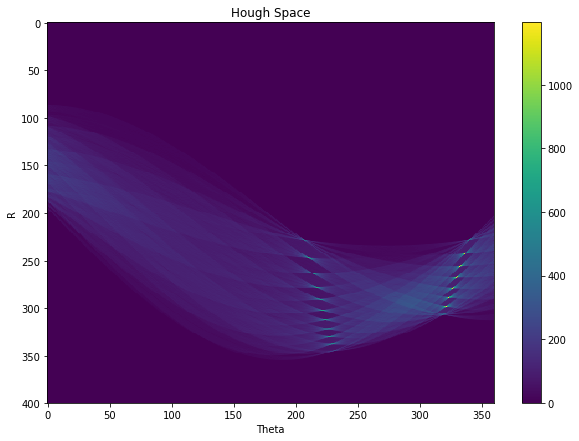

In [8]:
plt.figure(figsize=(10, 7)), plt.imshow(counts), plt.title("Hough Space"),
plt.xlabel("Theta"), plt.ylabel("R"), plt.axis('auto'), plt.colorbar();

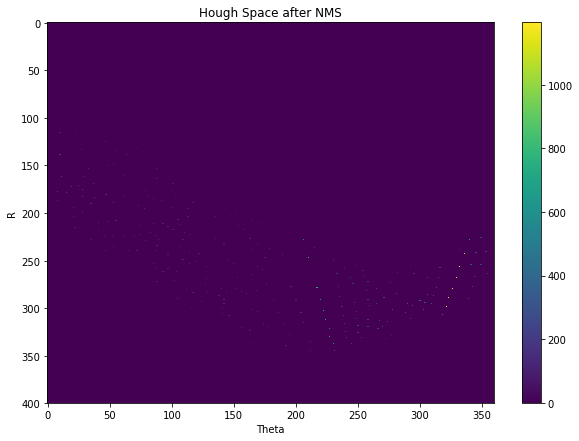

In [9]:
# We run non-local maxima supression in the Hough space to find the points which
# represent the major lines we are seeking
block_size = 7
half_block_size = int(np.floor(block_size / 2))
nms = np.zeros_like(counts, dtype=np.bool)
for i in range(half_block_size, counts.shape[0] - half_block_size):
    for j in range(half_block_size, counts.shape[1] - half_block_size):
        roi = counts[(i-half_block_size):(i+half_block_size+1), (j-half_block_size):(j+half_block_size+1)].copy()
        roi[half_block_size, half_block_size] = 0
        if counts[i, j] > np.max(roi):
            nms[i, j] = True
# Supress all non-local maxima in the Hough space
counts_nms = counts.copy()
counts_nms[~nms] = 0  # Keep only the local maximas

#plt.figure(figsize=(10, 5)), plt.imshow(nms), plt.title("Local maximum"), plt.axis('auto');
plt.figure(figsize=(10, 7)), plt.imshow(counts_nms), plt.title("Hough Space after NMS"),
plt.xlabel("Theta"), plt.ylabel("R"), plt.axis('auto'), plt.colorbar();

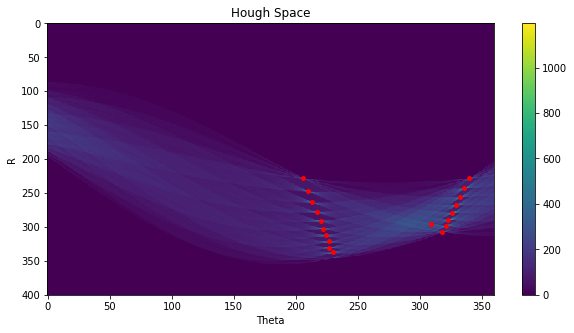

In [10]:
# Take The highest ones
n_max = grid_size[0] + grid_size[1] + 4 # We add 2 more lines for the border of each side
max_inds = np.argsort(counts_nms.ravel())[-n_max:]
maxima_y, maxima_x = np.unravel_index(max_inds, dims=counts_nms.shape)
maxima_xy = np.vstack((maxima_x, maxima_y)).T

plt.figure(figsize=(10, 5)), plt.imshow(counts), plt.title("Hough Space"),
plt.xlabel("Theta"), plt.ylabel("R"), plt.axis('auto'), plt.colorbar();
plt.scatter(maxima_xy[:, 0], maxima_xy[:, 1], marker='o', s=15, color='red');

(548, 0)

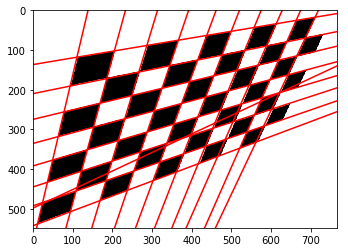

In [11]:
# Plot lines on image
plt.figure(), plt.imshow(im, cmap='gray')
for l_xy in maxima_xy:
    theta = theta_vec[l_xy[0]]
    r = r_vec[l_xy[1]]
    x1, y1 = 0, r/np.sin(theta)
    x2, y2 = r/np.cos(theta), 0
    plt.plot([x1, x2], [y1, y2], color='red')
plt.xlim([0, im.shape[1]])
plt.ylim([im.shape[0], 0])

We see we got all lines correct besides to most right one.

## Things to consider:

- Distorted lines - problem to use Hough transform to detect straight lines. For a robust algorithm we probably need to look on local features.

## Option 2

Use circular feature to find corners (like ORB). The chessboard corners has a distinctive response compared to other edges.

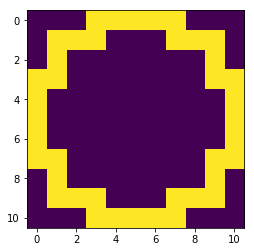

In [12]:
# Create template patch
r = 5
block_size = r*2 + 1
theta_vec = np.linspace(0, 2*np.pi, 360)
xy = np.vstack([r*np.cos(theta_vec), r*np.sin(theta_vec)]).T
xy = np.round(xy+r).astype(int)
patch = np.zeros((block_size, block_size), dtype=np.bool)
patch[xy[:, 1], xy[:, 0]] = True

plt.figure(), plt.imshow(patch);

In [13]:
# Convolve it over the image
# corners = np.zeros_like(im, dtype=np.bool)
# for i in range(r, im.shape[0] - r):
#     for j in range(r, im.shape[1] - r):
#         roi = counts[(i-r):(i+r+1), (j-r):(j+r+1)].copy()
#         v = roi[patch]
# TODO 